# Asignement 3 = Stag Hunt model 
By Māra Učelniece 

- Response : there is not a specific data set we have to use, but just apply the evaluation of the structures to the EV's case that we are attempting to create policy interventions for. 

### Task : 
Evaluate how varying structures relate to policy and in which cases they might apply. 
   

In [4]:
# Imports 
    # Copied from exmaple notebook 
    
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np
import pandas as pd
import csv
import random
from typing import Iterable, List, Dict
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed


# Can import the functions from the course_matterial 
    # Example : from file import function
# from course_matterial.ev_core import *     
    # Example to import all functions
        # from ./course_matterial/ev_core.py import *
#print("Done")

C:\Users\Mara\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Mara\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## 0. Implement a network agent based model

In [5]:
from new_core import *
#%run new_core.py
print("Done")

Done


## 1. Baseline System Analysis

In [ ]:
# Evaluate trough plots 
# Noah doing this part 

## 2. Network Structure Analysis

Seems that the follwoing will be done with plots 
- speed of adoption,
- probability of reaching the high-adoption equilibrium,
- cluster formation,
- network-specific sensitivity to tipping

In [4]:
# Mara doing this part   

# Mainly could use ev_plotting for this,
    # but there is also some matterial in ev_experiments

In [6]:
# Speed of adoption

    # Quantified in a number
def calculate_adoption_rate(X_traj: np.ndarray) -> float:
    initial_adoption = X_traj[0]
    final_adoption = X_traj[-1]
    total_steps = len(X_traj)
    return (final_adoption - initial_adoption) / total_steps
    
    # Time to treashold ~> high adoption
        # May not capture overall dynamics 
def time_to_reach_threshold(X_traj: np.ndarray, threshold: float) -> int:
    for t, X in enumerate(X_traj):
        if X >= threshold:
            return t
    return len(X_traj)  # Return total steps if threshold not reached

    # Time series analysis : easy to interpret 
def plot_time_series(X_traj: np.ndarray, I_traj: np.ndarray, out_dir: str, X0: float, I0: float):
    t = np.arange(len(X_traj))
    plt.figure(figsize=(6, 4))
    plt.plot(t, X_traj, label="X(t)")
    plt.plot(t, I_traj, label="I(t)")
    plt.xlabel("time step")
    plt.ylabel("value")
    plt.title(f"Time series X/I  X0={X0:.2f}, I0={I0:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"timeseries_X0_{int(X0*100)}_I0_{int(I0*100)}.png"))
    plt.close()


# Probabaility of reaching high-adoption equilibrium 
    # Finan adoption fractio, but no account for fluctuation 
def calculate_final_adoption(X_traj: np.ndarray) -> float:
    return X_traj[-1]
    
    # Stability analysis 
def is_high_adoption_equilibrium(X_traj: np.ndarray, threshold: float) -> bool:
    return np.mean(X_traj[-10:]) >= threshold  # Check last 10 steps for stability

    # Probalistic measure to reach high adoption
def monte_carlo_high_adoption_probability(trials: int, model_params: dict, threshold: float) -> float:
    successes = 0
    for _ in range(trials):
        final_adoption, _ = run_trial(**model_params)
        if final_adoption >= threshold:
            successes += 1
    return successes / trials

# Cluster formation 
    # Clustering coeficient analysis ~> tendency 
def calculate_clustering_coefficient(G: nx.Graph) -> float:
    return nx.average_clustering(G)

    # Spatial Adoption patterns  
def plot_spatial_adoption(G: nx.Graph, node_agent_map: Dict[int, EVAgent], out_dir: str):
    fig, ax = plt.subplots(figsize=(6,6))
    pos = nx.spring_layout(G, seed=42)
    color_map = ["green" if agent.strategy=="C" else "red" for agent in node_agent_map.values()]
    nx.draw(G, pos, node_color=color_map, with_labels=True, ax=ax)
    plt.savefig(os.path.join(out_dir, "spatial_adoption.png"))
    plt.close(fig)  

    
# Could add comunity detection, to find distinct ones, 
    # But mainly useful doe understanding localised adoption patterns 
    
        # No need to add : discussed 

In [7]:
# Network-Specific sesnitivity to tipping 

    # Sensitivity analysis 
        # qunatifying impact of parameter changes on adoption 
def sensitivity_analysis(network_type: str, param_range: Iterable[float], model_params: dict, out_dir: str):
    results = []
    for param in param_range:
        model_params['beta_I'] = param
        final_adoption, _ = run_trial(**model_params)
        results.append(final_adoption)
    plt.plot(param_range, results, label=network_type)
    plt.xlabel('Parameter Value')
    plt.ylabel('Final Adoption')
    plt.title(f'Sensitivity Analysis for {network_type}')
    plt.legend()
    plt.savefig(os.path.join(out_dir, f"sensitivity_{network_type}.png"))
    plt.close()
    

    # Topping point estimation 
        # identifying critical points 
def estimate_tipping_point(X0_vals: List[float], I0_vals: List[float], model_params: dict, threshold: float, out_dir: str):
    tipping_points = []
    for X0 in X0_vals:
        for I0 in I0_vals:
            model_params['X0_frac'] = X0
            model_params['I0'] = I0
            final_adoption, _ = run_trial(**model_params)
            if final_adoption >= threshold:
                tipping_points.append((X0, I0))
    plt.scatter(*zip(*tipping_points))
    plt.xlabel('Initial Adoption X0')
    plt.ylabel('Initial Infrastructure I0')
    plt.title('Tipping Points')
    plt.savefig(os.path.join(out_dir, "tipping_points.png"))
    plt.close()
    
    
    # Phase plot analysis 
        # visualisation between adoption and infustructutre 
def plot_phase_trajectory(X_traj: np.ndarray, I_traj: np.ndarray, out_dir: str, X0: float, I0: float):
    plt.figure(figsize=(5, 5))
    plt.plot(I_traj, X_traj, marker=".", linewidth=1)
    plt.xlabel("I(t)")
    plt.ylabel("X(t)")
    plt.title(f"Phase plot X vs I  X0={X0:.2f}, I0={I0:.2f}")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"phase_X0_{int(X0*100)}_I0_{int(I0*100)}.png"))
    plt.close()

In [ ]:
# Final adoption 

In [8]:
# Adjustement of the main 
    # to include the senitivity analysis 

def main():
    out_dir = "output_second_part"
    os.makedirs(out_dir, exist_ok=True)

    # ---- Config ----
        # Payoff + dynamic parameters
    a0 = 2.0      # base payoff / benifit of cooperation
    b = 1.0       # defector payoff
    g_I = 0.05    # infastructure growth rate/ response 
    beta_I = 2.0  # network effect / additional benifit 
                        # / infastructure payoff 
    
        # Network parameters 
    network_type = "ER"  # "ER", "WS", or "BA"
    n_nodes = 200    # nr of agents 
    p = 0.05    # prob of edge existing / connection prob  
    m = 2       # nr of edges from node / for BA and WS ... 
    
    X0_frac = 0.1   # inital fraction of adopters 
    I0 = 0.5      # baseline benifit/initial infastructure  

        # Strategy update 
    strategy_choice_func = "imitate" # or "logit"
    # tau = 1.0        # temp for loglit 
    
        # Simulation parameters 
    T = 200     # nr of simulation steps 
    threshold = 0.9  # Adoption fraction
    trials = 30  # simulations for probabilities 

    

    model_params = {
        "X0_frac": X0_frac,
        "I0": I0,
        "a0": a0,
        "beta_I": beta_I,
        "b": b,
        "g_I": g_I,
        "T": T,
        "network_type": network_type,
        "n_nodes": n_nodes,
        "p": p,
        "m": m,
        "seed": 42,
        "strategy_choice_func": strategy_choice_func,
         # "tau": tau,  # sodt max randomness parameter 
        "record_trajectory": True, # ensures saving x and i over time 
    }

    # ---- Run a single trial ----
    final_adoption, (X_traj, I_traj) = run_trial(**model_params)

    # ---- Adoption metrics ----
    adoption_rate = calculate_adoption_rate(X_traj)
    time_to_thresh = time_to_reach_threshold(X_traj, threshold)
    final_adopt = calculate_final_adoption(X_traj)
    high_eq = is_high_adoption_equilibrium(X_traj, threshold)
    high_prob = monte_carlo_high_adoption_probability(trials, model_params, threshold)

    print(f"Final adoption: {final_adopt:.3f}")
    print(f"Adoption rate: {adoption_rate:.4f} per step")
    print(f"Time to reach threshold {threshold}: {time_to_thresh} steps")
    print(f"High adoption equilibrium: {high_eq}")
    print(f"Probability of reaching high adoption (Monte Carlo {trials} trials): {high_prob:.3f}")

    # ---- Network metrics ----
    G = EVStagHuntModel(
        initial_ev=int(round(X0_frac * n_nodes)),
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=42,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        strategy_choice_func=strategy_choice_func,
        #tau=tau,
    ).G

    clustering = calculate_clustering_coefficient(G)
    print(f"Average clustering coefficient: {clustering:.3f}")

    # ---- Phase plot ----
    plot_phase_trajectory(X_traj, I_traj, out_dir, X0_frac, I0)

    # ---- Spatial adoption ----
    node_agent_map = {i: EVAgent(i, None, "D") for i in G.nodes()}
    # Assign strategies from final adoption for plotting
    for i, agent in enumerate(node_agent_map.values()):
        agent.strategy = "C" if i < int(final_adoption * n_nodes) else "D"

    plot_spatial_adoption(G, node_agent_map, out_dir)

    print("Analysis completed. Plots and metrics saved to:", out_dir)

    
    plot_time_series(X_traj, I_traj, out_dir, X0_frac, I0)
    
if __name__ == "__main__":
    main()

Final adoption: 0.000
Adoption rate: -0.0003 per step
Time to reach threshold 0.9: 400 steps
High adoption equilibrium: False
Probability of reaching high adoption (Monte Carlo 30 trials): 0.000
Average clustering coefficient: 0.046
Analysis completed. Plots and metrics saved to: output_second_part


-------------------
# STOP HERE
----------------------

In [10]:
def main():
    out_dir = "output_second_part"
    os.makedirs(out_dir, exist_ok=True)

    # ---- Config ----
    a0 = 2.0
    b = 1.0
    g_I = 0.05
    beta_I = 2.0

    network_type = "ER"
    n_nodes = 200
    p = 0.05
    m = 2

    X0_frac = 0.1
    I0 = 0.5

    strategy_choice_func = "imitate"
    T = 200
    threshold = 0.9
    trials = 30

    model_params = {
        "X0_frac": X0_frac,
        "I0": I0,
        "a0": a0,
        "beta_I": beta_I,
        "b": b,
        "g_I": g_I,
        "T": T,
        "network_type": network_type,
        "n_nodes": n_nodes,
        "p": p,
        "m": m,
        "seed": 42,
        "strategy_choice_func": strategy_choice_func,
        "record_trajectory": True,
    }

    # ---- Run a single trial ----
    final_adoption, (X_traj, I_traj) = run_trial(**model_params)

    # ---- Adoption metrics ----
    adoption_rate = calculate_adoption_rate(X_traj)
    time_to_thresh = time_to_reach_threshold(X_traj, threshold)
    final_adopt = calculate_final_adoption(X_traj)
    high_eq = is_high_adoption_equilibrium(X_traj, threshold)
    high_prob = monte_carlo_high_adoption_probability(trials, model_params, threshold)

    print(f"Final adoption: {final_adopt:.3f}")
    print(f"Adoption rate: {adoption_rate:.4f} per step")
    print(f"Time to reach threshold {threshold}: {time_to_thresh} steps")
    print(f"High adoption equilibrium: {high_eq}")
    print(f"Probability of reaching high adoption (Monte Carlo {trials} trials): {high_prob:.3f}")

    # ---- Network metrics ----
    G = EVStagHuntModel(
        initial_ev=int(round(X0_frac * n_nodes)),
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=42,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        strategy_choice_func=strategy_choice_func
    ).G

    clustering = calculate_clustering_coefficient(G)
    print(f"Average clustering coefficient: {clustering:.3f}")

    
    # ---- Spatial adoption ----
    node_agent_map = {i: EVAgent(i, None, "D") for i in G.nodes()}
    for i, agent in enumerate(node_agent_map.values()):
        agent.strategy = "C" if i < int(final_adoption * n_nodes) else "D"

    plot_spatial_adoption(G, node_agent_map, out_dir)
    plot_time_series(X_traj, I_traj, out_dir, X0_frac, I0)

    print("Analysis completed. Plots and metrics saved to:", out_dir)

    
    # Network-specific anaklysis 

    print("Running sensitivity analysis...")
    beta_range = np.linspace(0.5, 4.0, 15)
    sensitivity_analysis(network_type, beta_range, model_params.copy(), out_dir)

    print("Estimating tipping points...")
    X0_vals = np.linspace(0.0, 0.3, 8)
    I0_vals = np.linspace(0.0, 1.0, 8)
    estimate_tipping_point(X0_vals, I0_vals, model_params.copy(), threshold, out_dir)

    plot_phase_trajectory(X_traj, I_traj, out_dir, X0_frac, I0)
        
    print("Extended analysis complete.")
    

    
if __name__ == "__main__":
    main()

Final adoption: 0.000
Adoption rate: -0.0003 per step
Time to reach threshold 0.9: 400 steps
High adoption equilibrium: False
Probability of reaching high adoption (Monte Carlo 30 trials): 0.000
Average clustering coefficient: 0.046
Analysis completed. Plots and metrics saved to: output_second_part
Running sensitivity analysis...
Estimating tipping points...
Extended analysis complete.


### Result evaluation 
After a few runs : 
- ER :
    - If the adoption rte is even sligtly negative, with even values of -0.0005, then the final adoption is 0 not 1. 
    - The average clustering coeficient is about 0.5 in with current adjusments inn  almost all of teh parameters .

- WS 
.... 

### Discussion with Noah

Just stick to the one value of clustering coeficient for cluster formaton evaluation, yes? 

For the time series plot adjsutemnts they will depend on the policy implementations that we are going to discuss 

        Infastructure, and time 

For the sensitivity check heatmap and the possible three implemented. 


#### Task further:  

For policy intervention => the network represents the area, but as a general depiction, as they do not fully represtent ... 
    
Mara = infastructure shocks 

    Do the comparison with local as high centrality vs global 
    
    Do global frisrt and then base local on the targetted seeding noah does . 
    
    General vs targeted infastructure schocks -> now what i do 
    
    
Noah = targeted seeding 


## 3. Policy Intervention Designand Evaluation

In [5]:
# For this one the ev_experiments mainly perevelent: 
    # policy_subsidy_factory = Create a policy that temporarily boosts coordination payoffs
    # policy_infrastructure_boost_factory = Create a policy that injects infrastructure at a specific step
    
# However, these are only two interventions, and we wnat to test possibly more or others 
    # Can still be used for insparation / a basis to start from 

    
# For degree centrality ... 

Running Baseline (Random Seeding)...
Running Intervention (Degree Seeding)...


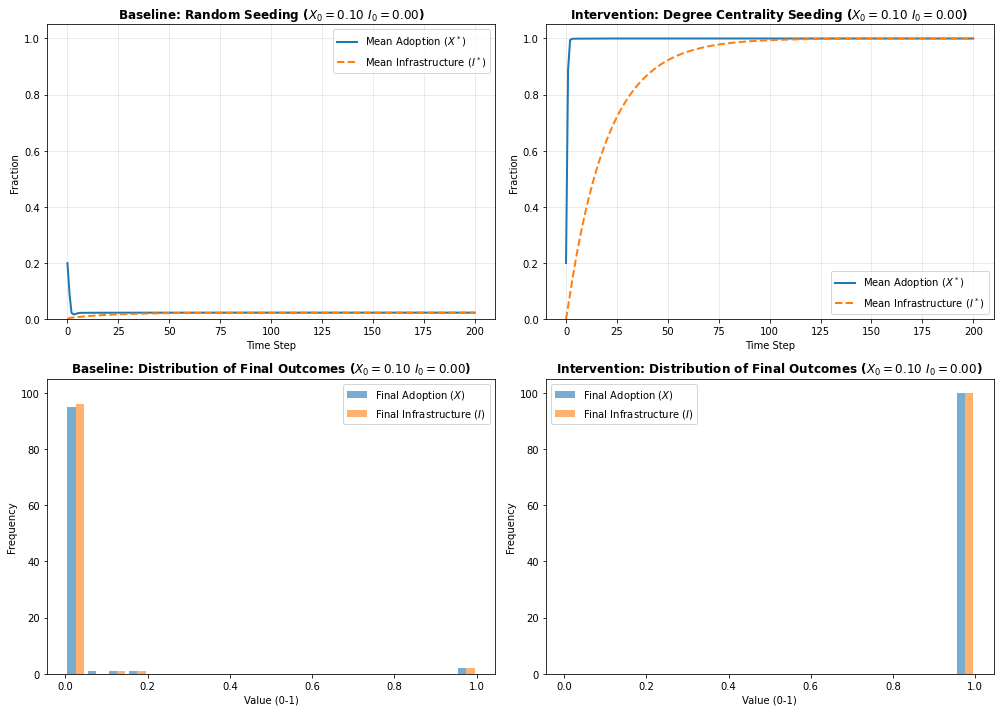

In [20]:
# Copied from Noah 

# --- 1. Helper Function for Targeted Seeding ---
def apply_seeding(model, X0_frac, method="random"):
    """
    Applies specific seeding strategies to the provided model instance.
    Adapts the logic to work with model.node_agent_map.
    """
    nodes = list(model.G.nodes())
    total_nodes = len(nodes)
    k_ev = int(round(X0_frac * total_nodes))
    
    # Reset all agents to Defect first
    for agent in model.node_agent_map.values():
        agent.strategy = "D"
        agent.next_strategy = "D"

    target_nodes = []

    if method == "random":
        target_nodes = random.sample(nodes, k_ev)
        
    elif method == "degree":
        # Sort nodes by degree (high to low)
        degrees = dict(model.G.degree())
        # Sort keys by value descending
        sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
        target_nodes = sorted_nodes[:k_ev]

    # Apply "C" strategy to chosen targets
    for node_id in target_nodes:
        model.node_agent_map[node_id].strategy = "C"
        model.node_agent_map[node_id].next_strategy = "C"

# --- 2. Simulation Runner ---
def run_batch(n_trials, steps, method, params):
    """
    Runs a batch of simulations and returns trajectories and final states.
    """
    X_trajectories = []
    I_trajectories = []
    final_X = []
    final_I = []

    for i in range(n_trials):
        # Initialize model with 0 initial EVs so we can manually seed them
        model = EVStagHuntModel(
            initial_ev=0, 
            a0=params['a0'], beta_I=params['beta_I'], b=params['b'], 
            g_I=params['g_I'], I0=params['I0'], 
            seed=None, # Random seed for stochasticity
            network_type=params['network_type'], 
            n_nodes=params['n_nodes'], p=params['p'], m=params['m'],
            strategy_choice_func=params['func']
        )
        
        # Apply the specific seeding method (Random vs Degree)
        apply_seeding(model, params['X0_frac'], method=method)
        
        # storage for this trial
        trial_X = []
        trial_I = []
        
        # Run time steps
        for t in range(steps):
            trial_X.append(model.get_adoption_fraction())
            trial_I.append(model.infrastructure)
            model.step()
            
        # Capture final state
        trial_X.append(model.get_adoption_fraction())
        trial_I.append(model.infrastructure)
        
        X_trajectories.append(trial_X)
        I_trajectories.append(trial_I)
        final_X.append(trial_X[-1])
        final_I.append(trial_I[-1])

    return np.array(X_trajectories), np.array(I_trajectories), np.array(final_X), np.array(final_I)

# --- 3. Configuration ---
# Parameters chosen to be near a tipping point where seeding matters
PARAMS = {
    'a0': 2.0,          
    'beta_I': 2,     # Strong feedback to allow tipping
    'b': 1.0,           # Defection payoff
    'g_I': 0.05,         # Infrastructure growth rate
    'I0': 0.00,          # Start with no infrastructure
    'X0_frac': 0.20,     # 10% Initial adopters (Low initial seed)
    'network_type': 'BA', # Scale-free networks show high sensitivity to hubs
    'n_nodes': 200,
    'p': 0.05,           # For ER/WS
    'm': 2,             # For BA (edges per new node)
    'func': 'imitate'
}

TRIALS = 100
STEPS = 200

# --- 4. Execute Simulations ---
print("Running Baseline (Random Seeding)...")
base_X_traj, base_I_traj, base_final_X, base_final_I = run_batch(TRIALS, STEPS, "random", PARAMS)

print("Running Intervention (Degree Seeding)...")
seed_X_traj, seed_I_traj, seed_final_X, seed_final_I = run_batch(TRIALS, STEPS, "degree", PARAMS)

# Calculate Means
base_mean_X = np.mean(base_X_traj, axis=0)
base_mean_I = np.mean(base_I_traj, axis=0)
seed_mean_X = np.mean(seed_X_traj, axis=0)
seed_mean_I = np.mean(seed_I_traj, axis=0)

# --- 5. Visualization ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
time_axis = range(STEPS + 1)

# Style settings
color_X = '#1f77b4' # Blue
color_I = '#ff7f0e' # Orange
alpha_hist = 0.6
bins_count = 20

# --- Top Left: Baseline Dynamics ---
axs[0, 0].plot(time_axis, base_mean_X, label=r'Mean Adoption ($X^*$)', color=color_X, linewidth=2)
axs[0, 0].plot(time_axis, base_mean_I, label=r'Mean Infrastructure ($I^*$)', color=color_I, linewidth=2, linestyle='--')
axs[0, 0].set_title(r'Baseline: Random Seeding ($X_0=0.10$ $I_0=0.00$)', fontsize=12, fontweight='bold')
axs[0, 0].set_xlabel('Time Step')
axs[0, 0].set_ylabel('Fraction')
axs[0, 0].set_ylim(0, 1.05)
axs[0, 0].grid(True, alpha=0.3)
axs[0, 0].legend()

# --- Bottom Left: Baseline Histogram ---
axs[1, 0].hist(
    [base_final_X, base_final_I], # Group data into a list for combined plotting
    bins=bins_count, 
    range=(0,1), 
    alpha=alpha_hist, 
    color=[color_X, color_I], # Set colors for the two datasets
    label=['Final Adoption ($X$)', 'Final Infrastructure ($I$)']
)
axs[1, 0].set_title(r'Baseline: Distribution of Final Outcomes ($X_0=0.10$ $I_0=0.00$)', fontsize=12, fontweight='bold')
axs[1, 0].set_xlabel('Value (0-1)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_ylim (0, 105)
axs[1, 0].legend()

# --- Top Right: Targeted Seeding Dynamics ---
axs[0, 1].plot(time_axis, seed_mean_X, label=r'Mean Adoption ($X^*$)', color=color_X, linewidth=2)
axs[0, 1].plot(time_axis, seed_mean_I, label=r'Mean Infrastructure ($I^*$)', color=color_I, linewidth=2, linestyle='--')
axs[0, 1].set_title(r'Intervention: Degree Centrality Seeding ($X_0=0.10$ $I_0=0.00$)', fontsize=12, fontweight='bold')
axs[0, 1].set_xlabel('Time Step')
axs[0, 1].set_ylabel('Fraction')
axs[0, 1].set_ylim(0, 1.05)
axs[0, 1].grid(True, alpha=0.3)
axs[0, 1].legend()

# --- Bottom Right: Targeted Seeding Histogram ---
axs[1, 1].hist(
    [seed_final_X, seed_final_I], # Group data into a list for combined plotting
    bins=bins_count, 
    range=(0,1), 
    alpha=alpha_hist, 
    color=[color_X, color_I], # Set colors for the two datasets
    label=['Final Adoption ($X$)', 'Final Infrastructure ($I$)']
)
axs[1, 1].set_title(r'Intervention: Distribution of Final Outcomes ($X_0=0.10$ $I_0=0.00$)', fontsize=12, fontweight='bold')
axs[1, 1].set_xlabel('Value (0-1)')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_ylim (0, 105)
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Infastructure shocks 


In [21]:
def run_batch_single_shock(n_trials, steps, method, params, shock_time, shock_amount):
    """
    Runs simulations with a single global infrastructure shock at a given time.
    shock_amount: additive change to I (e.g., +0.2 or -0.1)
    shock_time: timestep where shock occurs
    """
    X_trajectories = []
    I_trajectories = []

    for _ in range(n_trials):
        model = EVStagHuntModel(
            initial_ev=0,
            a0=params['a0'], beta_I=params['beta_I'], b=params['b'],
            g_I=params['g_I'], I0=params['I0'], seed=None,
            network_type=params['network_type'], n_nodes=params['n_nodes'],
            p=params['p'], m=params['m'],
            strategy_choice_func=params['func']
        )

        apply_seeding(model, params['X0_frac'], method)

        trial_X = []
        trial_I = []

        for t in range(steps):
            # Apply global infrastructure shock
            if t == shock_time:
                model.infrastructure = np.clip(model.infrastructure + shock_amount, 0, 1)

            trial_X.append(model.get_adoption_fraction())
            trial_I.append(model.infrastructure)
            model.step()

        # Add final state
        trial_X.append(model.get_adoption_fraction())
        trial_I.append(model.infrastructure)

        X_trajectories.append(trial_X)
        I_trajectories.append(trial_I)

    return np.array(X_trajectories), np.array(I_trajectories)


In [17]:
# Bs copied from code above 
def plot_simulation_results(
        X_traj, I_traj, title_prefix, 
        steps, bins=20, color_X="#1f77b4", color_I="#ff7f0e"
    ):

    mean_X = np.mean(X_traj, axis=0)
    mean_I = np.mean(I_traj, axis=0)
    final_X = X_traj[:, -1]
    final_I = I_traj[:, -1]
    time_axis = range(steps + 1)

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))


    axs[0].plot(time_axis, mean_X, label='Mean Adoption $X(t)$',
                color=color_X, linewidth=2)
    axs[0].plot(time_axis, mean_I, label='Mean Infrastructure $I(t)$',
                color=color_I, linewidth=2, linestyle='--')

    axs[0].set_title(f"{title_prefix}: Dynamics of X(t) and I(t)",
                     fontsize=13, fontweight='bold')
    axs[0].set_xlabel("Time Step")
    axs[0].set_ylabel("Fraction")
    axs[0].set_ylim(0, 1.05)
    axs[0].grid(True, alpha=0.3)
    axs[0].legend()

    
    axs[1].hist(
        [final_X, final_I],
        bins=bins,
        range=(0, 1),
        alpha=0.7,
        color=[color_X, color_I],
        label=["Final Adoption (X)", "Final Infrastructure (I)"]
    )

    axs[1].set_title(f"{title_prefix}: Distribution of Final Outcomes",
                     fontsize=13, fontweight='bold')
    axs[1].set_xlabel("Value (0–1)")
    axs[1].set_ylabel("Frequency")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


In [18]:
def run_single_shock_with_plots(n_trials, steps, method, params, shock_time, shock_amount):
# Runs a batch of simulations with one infrastructure shock and produces

    X_traj, I_traj = run_batch_single_shock(
        n_trials, steps, method, params,
        shock_time=shock_time,
        shock_amount=shock_amount
    )

    title = f"Single Shock @ t={shock_time}, ΔI={shock_amount}"
    plot_simulation_results(X_traj, I_traj, title, steps)

    return X_traj, I_traj


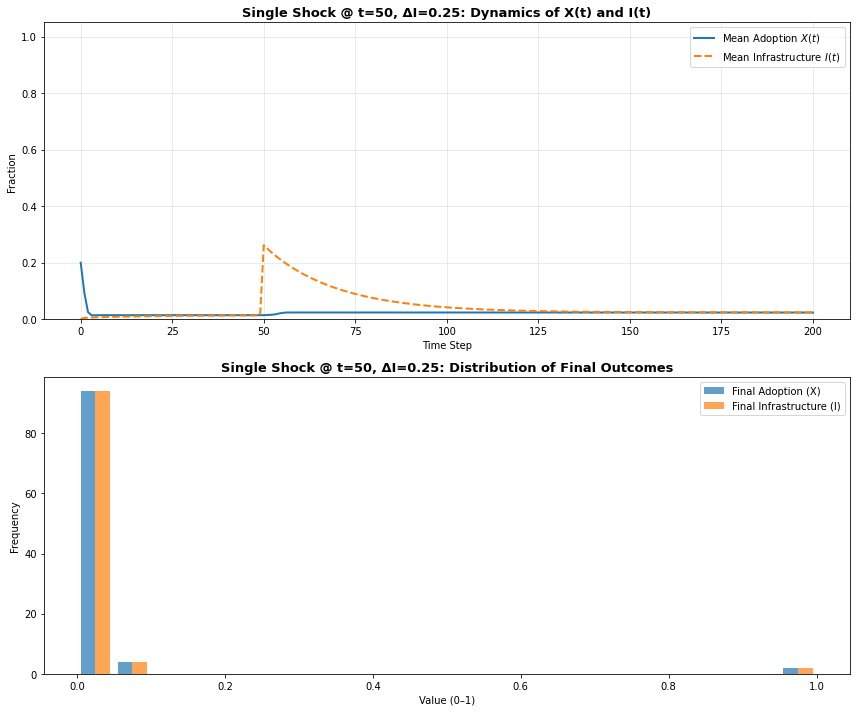

(array([[0.2  , 0.03 , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.2  , 0.04 , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.2  , 0.115, 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.2  , 0.045, 0.   , ..., 0.   , 0.   , 0.   ],
        [0.2  , 0.335, 0.095, ..., 0.   , 0.   , 0.   ],
        [0.2  , 0.255, 0.165, ..., 0.   , 0.   , 0.   ]]),
 array([[0.        , 0.0015    , 0.001425  , ..., 0.00012625, 0.00011994,
         0.00011394],
        [0.        , 0.002     , 0.0019    , ..., 0.00012627, 0.00011996,
         0.00011396],
        [0.        , 0.00575   , 0.0054625 , ..., 0.00012643, 0.00012011,
         0.0001141 ],
        ...,
        [0.        , 0.00225   , 0.0021375 , ..., 0.00012628, 0.00011997,
         0.00011397],
        [0.        , 0.01675   , 0.0206625 , ..., 0.00012709, 0.00012074,
         0.0001147 ],
        [0.        , 0.01275   , 0.0203625 , ..., 0.00012707, 0.00012072,
         0.00011468]]))

In [22]:
run_single_shock_with_plots(
    TRIALS, STEPS, "random", PARAMS,
    shock_time=50,
    shock_amount=+0.25
)
